## Preprocessing (pipeline)

In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders import WOEEncoder 
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

c:\Users\lenne\anaconda3\envs\AA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


BayesSearchCV uses Bayesian optimization techniques to search for the best hyperparameters.
It employs a probabilistic model to approximate the objective function (model performance) and decides the next set of hyperparameters to evaluate based on this approximation.
Unlike GridSearchCV, it does not search through all possible combinations of hyperparameters. Instead, it iteratively selects the most promising set of hyperparameters based on the model's performance observed so far.
Bayesian optimization tends to be more efficient in finding good hyperparameters compared to grid search, especially for high-dimensional or continuous hyperparameter spaces.

In summary, while GridSearchCV performs an exhaustive search over a predefined grid of hyperparameters, BayesSearchCV uses Bayesian optimization to efficiently explore the hyperparameter space and find promising configurations. BayesSearchCV is often preferred when dealing with complex or high-dimensional hyperparameter spaces where an exhaustive search becomes impractical.

#### Load the data

In [2]:
data_train = pd.read_csv('../datasets/train.csv')
data_test = pd.read_csv('../datasets/test.csv')
pd.set_option('display.max_columns', None)

### **missing for now: outlier detection**
### **also look into this encoder for categorical variables: from category_encoders.cat_boost import CatBoostEncoder**

Random Forests, being an ensemble of decision trees, are generally not sensitive to the scale of numeric features. The reason is that decision trees make splits based on feature values but do not rely on the absolute scale of those values. Therefore, in many cases, scaling is not a strict requirement when using Random Forests. --> no standardization for now so we keep interpretability

### Modeling
- we get (1) a labeled dataset (train.csv) and (2) an unlabeled dataset (test.csv)
- split train.csv into a train and test set
- that train set, u should split into train and validation sets (stratified CV split because imbalance)
- that test set has labels, so u can compare the predictions on X_test, y_test with the labels to evaluate performance of the different models **NOTE: to fit a model on the test set that is coming from train.csv, u need to pass the tuned values of the hyperparameters (tuned on the validation set)**
- choose the best performing model 
- then make predictions on test.csv (unlabeled) and export to a csv file which you upload to the website

 note: after finding the optimal parameters, put the values in the pipeline (paramters of RandomForestRegressor)

### Other ideas 
- change objective function? to account for top 20 evaluation metric?
- use proftree? proflogit?

#### Missing values

In [3]:
# For training data
missing_count = data_train.isnull().sum() 
missing_data = pd.DataFrame({'Column Name': missing_count.index, 'Missing Count': missing_count.values})
missing_data = missing_data.sort_values(by='Missing Count', ascending=False)
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data

,Column Name,Missing Count
22,Dropped_calls_ratio,4
23,Usage_Band,4
25,call_cost_per_min,4


In [4]:
rows_with_missing_values_train = data_train[data_train.isnull().any(axis=1)]
print("Rows with Missing Values in training data:")
rows_with_missing_values_train

Rows with Missing Values in training data:


,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target,id
1736,F,48.0,26/07/98,26.966667,2.0,Play 100,BS110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,0,K244380
3237,F,34.0,22/03/97,43.333333,2.0,Play 100,BS110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,0,K244320
3836,M,21.0,03/01/96,58.133333,2.0,Play 100,CAS30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,1,K213590
4301,F,22.0,08/08/98,26.533333,5.0,Play 100,CAS30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-600.0,NaN,0.0,0.0,59.94,OK,0.5,0.0,0.0,0.0,0.0,F,T,1,K212820


In [5]:
# For test data
missing_count = data_test.isnull().sum() 
missing_data = pd.DataFrame({'Column Name': missing_count.index, 'Missing Count': missing_count.values})
missing_data = missing_data.sort_values(by='Missing Count', ascending=False)
missing_data = missing_data[missing_data['Missing Count'] > 0]
missing_data

,Column Name,Missing Count
22,Dropped_calls_ratio,1
23,Usage_Band,1
25,call_cost_per_min,1


In [6]:
rows_with_missing_values_test = data_test[data_test.isnull().any(axis=1)]
print("\nRows with Missing Values in test data:")
rows_with_missing_values_test


Rows with Missing Values in test data:


,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,id
1389,F,34.0,07/09/98,24.858347,2.0,Play 100,BS110,7.0,0.092169,2.0,12.29251,2.0,-3.12627,-3.215572,-5.011147,3.519628,2.912569,0.27729,-22.0,-2.090036,-0.10749,-20.274408,NaN,NaN,-599.241325,NaN,-3.291928,-2.74686,66.563274,OK,0.510543,0.001085,-0.017429,-0.003596,-0.004193,F,T,K689673


**we will impute this since it's so little rows**

In [7]:
target_column = 'target'

# Separate features and target variable
X_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column]

X_test = data_test

don't know if this should be done after splitting or not -- still need to change this so that test uses the same day 1 as train data

In [8]:
def process_date_column(data, date_column):
    # Convert the date column to datetime format
    data[date_column] = pd.to_datetime(data[date_column], format='%d/%m/%y')

    # Find the earliest date
    earliest_date = data[date_column].min()

    # Convert the date column to days since the earliest date
    data[date_column] = (data[date_column] - earliest_date).dt.days

    return data

X_train = process_date_column(X_train, 'Connect_Date')
X_test = process_date_column(X_test, 'Connect_Date')

In [9]:
X_train.head()

,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,id
0,F,50.0,870,29.200000,2.0,Play 100,BS210,62.0,153.000000,185.0,438.600001,4.0,29.0,126.002615,2.045727,2.467742,2.370811,7.25,251.0,620.600001,2.472510,746.602616,0.003984,Med,20.600001,9.930712,2.045727,52.446773,112.386773,OK,0.150531,0.246536,0.706735,0.046729,0.203034,F,F,K262360
1,M,25.0,350,46.533333,1.0,CAT 100,ASAD90,146.0,718.800000,98.0,164.700000,4.0,37.2,251.580636,41.072379,4.923288,1.680612,9.30,248.0,920.700000,3.712500,1172.280636,0.002016,Med,320.700000,12.807103,41.072380,116.546571,221.546571,OK,0.188988,0.780710,0.178886,0.040404,0.273249,F,F,K170160
2,F,46.0,604,38.066667,1.0,CAT 50,WC95,160.0,322.800000,7.0,123.900000,0.0,0.0,91.584877,21.575073,2.017500,17.700000,0.00,167.0,446.700000,2.674850,538.284877,0.002994,MedLow,146.700000,12.226326,17.936021,45.411484,128.811484,OK,0.239300,0.722633,0.277367,0.000000,0.205025,F,F,K331610
3,F,59.0,924,27.400000,1.0,CAT 50,BS110,84.0,317.400001,57.0,161.699999,0.0,0.0,23.998036,20.950771,3.778571,2.836842,0.00,141.0,479.100000,3.397872,503.098036,0.003546,MedLow,179.100000,11.624922,20.820235,28.019646,111.419646,OK,0.221467,0.662492,0.337508,0.000000,0.050090,F,F,K332460
4,F,25.0,1103,21.433333,1.0,Play 300,WC95,14.0,309.600000,326.0,637.800000,6.0,14.4,87.051515,0.000000,22.114286,1.956442,2.40,346.0,961.800000,2.779769,1048.851515,0.001445,Med,-838.200000,9.403618,0.000000,34.820606,112.760606,OK,0.107509,0.321896,0.663132,0.014972,0.090509,F,F,K394220


#### Check the correlation

In [10]:
X_train['average cost min'].describe()

count    5044.000000
mean        0.168484
std         0.078024
min         0.048998
25%         0.134453
50%         0.154474
75%         0.179141
max         1.357564
Name: average cost min, dtype: float64

In [11]:
# Assuming X_train is a DataFrame
numerical_columns = X_train.select_dtypes(include=['number'])

# Display the numerical columns
numerical_columns

,Age,Connect_Date,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio
0,50.0,870,29.200000,2.0,62.0,153.000000,185.0,438.600001,4.0,29.000000,126.002615,2.045727,2.467742,2.370811,7.250000,251.0,620.600001,2.472510,746.602616,0.003984,20.600001,9.930712,2.045727,52.446773,112.386773,0.150531,0.246536,0.706735,0.046729,0.203034
1,25.0,350,46.533333,1.0,146.0,718.800000,98.0,164.700000,4.0,37.200000,251.580636,41.072379,4.923288,1.680612,9.300000,248.0,920.700000,3.712500,1172.280636,0.002016,320.700000,12.807103,41.072380,116.546571,221.546571,0.188988,0.780710,0.178886,0.040404,0.273249
2,46.0,604,38.066667,1.0,160.0,322.800000,7.0,123.900000,0.0,0.000000,91.584877,21.575073,2.017500,17.700000,0.000000,167.0,446.700000,2.674850,538.284877,0.002994,146.700000,12.226326,17.936021,45.411484,128.811484,0.239300,0.722633,0.277367,0.000000,0.205025
3,59.0,924,27.400000,1.0,84.0,317.400001,57.0,161.699999,0.0,0.000000,23.998036,20.950771,3.778571,2.836842,0.000000,141.0,479.100000,3.397872,503.098036,0.003546,179.100000,11.624922,20.820235,28.019646,111.419646,0.221467,0.662492,0.337508,0.000000,0.050090
4,25.0,1103,21.433333,1.0,14.0,309.600000,326.0,637.800000,6.0,14.400000,87.051515,0.000000,22.114286,1.956442,2.400000,346.0,961.800000,2.779769,1048.851515,0.001445,-838.200000,9.403618,0.000000,34.820606,112.760606,0.107509,0.321896,0.663132,0.014972,0.090509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,16.0,623,37.433333,2.0,151.0,1169.400001,201.0,657.900000,34.0,71.400001,242.983418,56.451295,7.744371,3.273134,2.100000,386.0,1898.700002,4.918912,2141.683420,0.002591,698.700002,8.079475,56.451295,129.346320,279.346320,0.130433,0.615895,0.346500,0.037605,0.127974
5040,29.0,271,49.166667,1.0,135.0,405.600000,124.0,301.200001,11.0,23.000000,174.140881,13.703878,3.004444,2.429032,2.090909,270.0,729.800001,2.702963,903.940882,0.001852,129.800001,10.557687,13.703878,65.946142,170.946142,0.189112,0.555769,0.412716,0.031515,0.238615
5041,23.0,1254,16.400000,0.0,566.0,2382.000000,4.0,477.300000,13.0,81.000000,126.710085,157.507716,4.208481,119.325000,6.230769,583.0,2940.300000,5.043396,3067.010085,0.000000,1740.300000,9.050607,157.507715,195.520741,345.520741,0.112657,0.810121,0.162330,0.027548,0.043094
5042,46.0,790,31.866667,2.0,72.0,112.200000,31.0,230.700000,2.0,4.200000,59.510484,0.000000,1.558333,7.441935,2.100000,105.0,347.100000,3.305714,406.610484,0.009524,-252.900000,11.464996,0.000000,23.804194,83.744194,0.205957,0.323250,0.664650,0.012100,0.171451


In [12]:
# Assuming X_train is a DataFrame containing numerical variables
correlation_matrix = numerical_columns.corr()
correlation_matrix

,Age,Connect_Date,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio
Age,1.000000,0.002815,-0.002815,-0.009890,0.024418,0.030537,0.021792,0.027908,0.006568,-0.002776,0.063056,0.015425,-0.002732,-0.010142,-0.013296,0.031166,0.038336,-0.006985,0.046824,0.007936,-0.000056,-0.029689,0.016691,0.054192,0.054017,-0.002463,0.007833,-0.001407,-0.022764,0.054239
Connect_Date,0.002815,1.000000,-1.000000,0.040194,0.001641,0.000086,-0.008715,0.000179,-0.019537,-0.021033,0.000480,-0.003634,-0.014094,0.011610,0.007240,-0.003003,-0.001249,0.002701,-0.000960,0.018905,-0.005385,-0.006188,-0.003848,-0.001922,-0.000758,0.005906,-0.000735,0.001476,0.002257,0.012513
L_O_S,-0.002815,-1.000000,1.000000,-0.040194,-0.001641,-0.000086,0.008715,-0.000179,0.019537,0.021033,-0.000480,0.003634,0.014094,-0.011610,-0.007240,0.003003,0.001249,-0.002701,0.000960,-0.018905,0.005385,0.006188,0.003848,0.001922,0.000758,-0.005906,0.000735,-0.001476,-0.002257,-0.012513
Dropped_Calls,-0.009890,0.040194,-0.040194,1.000000,0.010742,-0.011166,-0.014460,-0.007442,-0.005082,-0.004014,-0.007646,0.001037,0.002684,-0.009139,0.001028,0.004143,-0.013340,0.004399,-0.013100,0.502732,0.001088,0.003123,0.000886,-0.006204,-0.008458,0.026043,-0.008395,0.001767,0.023422,-0.003192
Peak_calls_Sum,0.024418,0.001641,-0.001641,0.010742,1.000000,0.721243,0.001002,-0.001291,0.010370,0.019843,0.368751,0.579788,-0.168477,0.024378,0.011565,0.924017,0.669293,-0.346386,0.653933,-0.210439,0.532075,-0.189352,0.579429,0.497165,0.618206,-0.239119,0.509799,-0.446650,-0.307368,-0.060080
Peak_mins_Sum,0.030537,0.000086,-0.000086,-0.011166,0.721243,1.000000,0.002308,-0.000999,-0.001998,0.021848,0.528560,0.800112,0.019702,0.011672,0.015074,0.666440,0.927886,0.050496,0.910463,-0.190505,0.739927,-0.270956,0.799651,0.699472,0.867152,-0.333495,0.706531,-0.617735,-0.429908,-0.072592
OffPeak_calls_Sum,0.021792,-0.008715,0.008715,-0.014460,0.001002,0.002308,1.000000,0.683739,0.002303,-0.000188,0.167602,0.079465,-0.005431,-0.254009,-0.004684,0.378036,0.252471,-0.266203,0.253044,-0.166747,-0.056250,-0.321872,0.082603,0.192098,0.130201,-0.291978,-0.361876,0.442678,-0.173840,-0.003818
OffPeak_mins_Sum,0.027908,0.000179,-0.000179,-0.007442,-0.001291,-0.000999,0.683739,1.000000,0.010874,0.011838,0.234237,0.084522,-0.000507,0.042959,0.007048,0.257241,0.365999,-0.035640,0.364879,-0.126383,-0.115272,-0.458504,0.089204,0.263781,0.175774,-0.443074,-0.529378,0.648619,-0.257561,-0.011028
Weekend_calls_Sum,0.006568,-0.019537,0.019537,-0.005082,0.010370,-0.001998,0.002303,0.010874,1.000000,0.704562,0.031030,0.023812,-0.002454,0.028906,-0.274981,0.073528,0.048842,-0.084166,0.048642,-0.068507,-0.004426,-0.066747,0.025714,0.042081,0.022870,-0.088831,-0.089605,-0.032822,0.435712,-0.000364
Weekend_mins_Sum,-0.002776,-0.021033,0.021033,-0.004014,0.019843,0.021848,-0.000188,0.011838,0.704562,1.000000,0.047608,0.043017,-0.004542,0.013357,0.155437,0.062695,0.090883,-0.032993,0.088247,-0.059971,0.015489,-0.107495,0.045792,0.064215,0.050310,-0.150095,-0.102163,-0.066129,0.594431,-0.015193


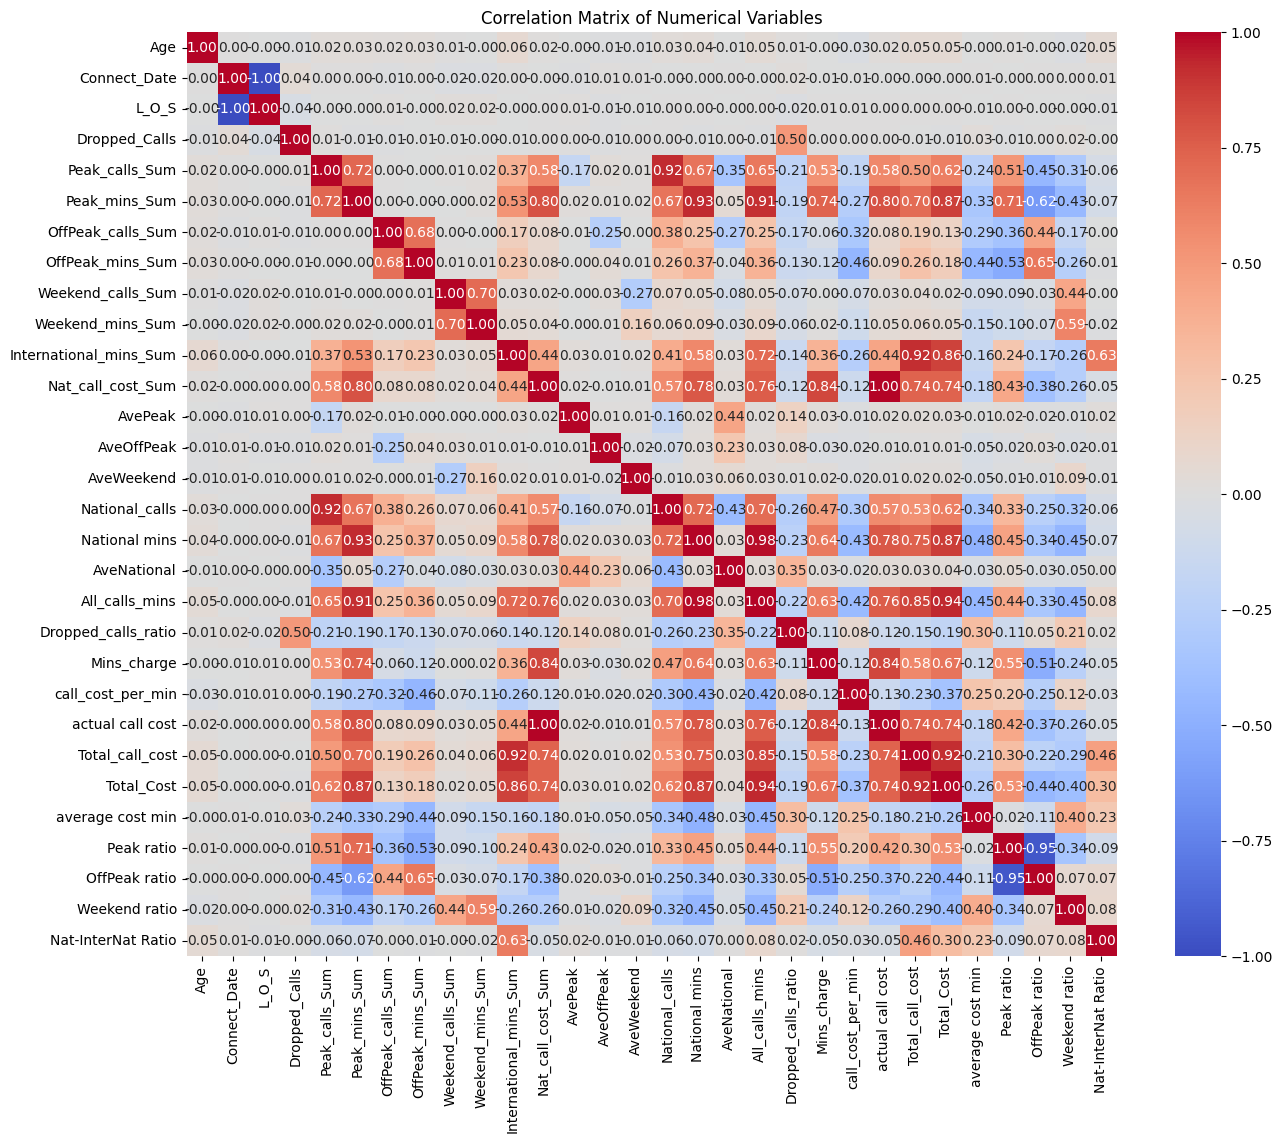

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

#### Split data into train and validation set 

target variable is binary and imbalanced (with the minority class having a frequency of 15%), so using a stratified splitting approach is recommended to ensure that both the training and validation sets have a similar distribution of the target variable.

In [14]:
stratified_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, valid_index in stratified_splitter.split(X_train, y_train):
    X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_split, y_valid_split = y_train.iloc[train_index], y_train.iloc[valid_index]
    # Now you can use X_train_split, y_train_split for training and X_valid_split, y_valid_split for validation

In [15]:
total_train_samples = X_train_split.shape[0] + X_valid_split.shape[0]
train_distribution_percentage = (X_train_split.shape[0]/ total_train_samples) * 100
validation_distribution_percentage = (X_valid_split.shape[0] / total_train_samples) * 100

print(f"Training Set Distribution: {train_distribution_percentage:.2f}% ({X_train_split.shape[0]} rows)")
print(f"Validation Set Distribution: {validation_distribution_percentage:.2f}% ({X_valid_split.shape[0]} rows)")

Training Set Distribution: 80.02% (4036 rows)
Validation Set Distribution: 19.98% (1008 rows)


#### Pipeline

In [16]:
X_train_split['Tariff_OK'] = np.where(X_train_split['Tariff_OK'] == 'OK', 1, 0)
X_valid_split['Tariff_OK'] = np.where(X_valid_split['Tariff_OK'] == 'OK', 1, 0)
X_test['Tariff_OK'] = np.where(X_test['Tariff_OK'] == 'OK', 1, 0)

C:\Users\lenne\AppData\Local\Temp\ipykernel_3936\328505691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_split['Tariff_OK'] = np.where(X_train_split['Tariff_OK'] == 'OK', 1, 0)
C:\Users\lenne\AppData\Local\Temp\ipykernel_3936\328505691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_split['Tariff_OK'] = np.where(X_valid_split['Tariff_OK'] == 'OK', 1, 0)


In [17]:
# Custom transformer to remove prefix from column names
class RemovePrefixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, prefixes):
        self.prefixes = prefixes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for prefix in self.prefixes:
            X.columns = [col.split(f'{prefix}__')[1] if f'{prefix}__' in col else col for col in X.columns]
        return X

you can handle them explicitly before preprocessing, for example, by replacing them with the most frequent category using fillna()

In [18]:
X_train_split = X_train_split.copy()
X_train_split['Usage_Band'] = X_train_split['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])
print(X_train_split['Usage_Band'].unique())

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_train_split['Dropped_calls_ratio'] = X_train_split['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_train_split['call_cost_per_min'] = X_train_split['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

['Med' 'MedLow' 'MedHigh' 'Low' 'High']


In [19]:
y_train_split = y_train_split.fillna(y_train_split.mode()[0])
y_valid_split = y_valid_split.fillna(y_train_split.mode()[0])

In [20]:
X_valid_split = X_valid_split.copy()

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_valid_split['Dropped_calls_ratio'] = X_valid_split['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_valid_split['call_cost_per_min'] = X_valid_split['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

# Handle missing values in 'Usage_Band' for X_validation_split
X_valid_split['Usage_Band'] = X_valid_split['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])

In [21]:
X_test = X_test.copy()
X_test['Usage_Band'] = X_test['Usage_Band'].fillna(X_train_split['Usage_Band'].mode()[0])
print(X_test['Usage_Band'].unique())

# Handle missing values in 'Dropped_calls_ratio' by filling with the median
X_test['Dropped_calls_ratio'] = X_test['Dropped_calls_ratio'].fillna(X_train_split['Dropped_calls_ratio'].median())

# Handle missing values in 'call_cost_per_min' by filling with the median
X_test['call_cost_per_min'] = X_test['call_cost_per_min'].fillna(X_train_split['call_cost_per_min'].median())

['MedHigh' 'Med' 'High' 'MedLow' 'Low']


In [22]:
# Define columns to drop
columns_to_drop = ['id', 'Connect_Date']  # Drop because it's not numerical, later on add it back to know which prediction corresponds to which individual

# Define columns for different encoding methods
one_hot_encode_columns = ['Gender', 'high Dropped calls', 'No Usage']
woe_encode_columns = ['tariff', 'Handset', 'Usage_Band'] #ipv ordinal endoding
PCA_columns = [
    'Age',
    'L_O_S',
    'Dropped_Calls',
    'Peak_calls_Sum',
    'Peak_mins_Sum',
    'OffPeak_calls_Sum',
    'OffPeak_mins_Sum',
    'Weekend_calls_Sum',
    'Weekend_mins_Sum',
    'International_mins_Sum',
    'Nat_call_cost_Sum',
    'AvePeak',
    'AveOffPeak',
    'AveWeekend',
    'National_calls',
    'National mins',
    'AveNational',
    'All_calls_mins',
    'Dropped_calls_ratio',
    'Mins_charge',
    'call_cost_per_min',
    'actual call cost',
    'Total_call_cost',
    'Total_Cost',
    'average cost min',
    'Peak ratio',
    'OffPeak ratio',
    'Weekend ratio',
    'Nat-InterNat Ratio'
]

# Define the PCA pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('pca', PCA(n_components=0.80))  # Apply PCA to retain 90% of the variance
])

# Modify the preprocessing pipeline to apply PCA only on PCA columns
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('one_hot_encode', OneHotEncoder(drop='first', sparse_output=False), one_hot_encode_columns),
        ('WOE_encode', WOEEncoder(), woe_encode_columns),
        ('pca', pca_pipeline, PCA_columns)  # Apply PCA only on PCA columns
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Build the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('remove_prefix', RemovePrefixTransformer(prefixes=['one_hot_encode', 'WOE_encode', 'pca', 'remainder']))   # Add this step to remove the prefix
])

rf_classifier=RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the final pipeline with PCA
lgb_pipeline_with_pca = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', rf_classifier)
])

In [23]:
def calculate_profit_metric_2(y_true, y_probabilities, dataset, top_k=20):
    # Reset indices of the dataset DataFrame
    dataset.reset_index(drop=True, inplace=True)
    
    # Convert y_probabilities to a DataFrame and then reset indices
    y_probabilities = pd.DataFrame(y_probabilities, columns=['Prob_0', 'Prob_1'])
    y_probabilities.reset_index(drop=True, inplace=True)

    # Now concatenate the DataFrames
    profit_df = pd.concat([dataset[['average cost min']], y_probabilities, y_true], axis=1)

    # Sort concatenated_df by PROB_1 column in descending order
    profit_df_sorted = profit_df.sort_values(by='Prob_1', ascending=False)

    # Filter the top 20 rows
    top_k_rows = profit_df_sorted.head(top_k)

    # Filter the top 20 rows where target == 1 (actual churner) and sum the 'average cost min' values
    profit_at_top_k = top_k_rows[top_k_rows[y_true.name] == 1]['average cost min'].sum()  
    
    return profit_at_top_k

from sklearn.metrics import make_scorer

# Define the custom scorer function
def profit_at_top_k_scorer(y_true, y_pred_proba, dataset, top_k=20):
    # Reset indices of the dataset DataFrame
    dataset.reset_index(drop=True, inplace=True)

    # Convert y_probabilities to a DataFrame and then reset indices
    y_pred_proba = pd.DataFrame(y_pred_proba, columns=['Prob_0', 'Prob_1'])
    y_pred_proba.reset_index(drop=True, inplace=True)

    # Now concatenate the DataFrames
    profit_df = pd.concat([dataset[['average cost min']], y_pred_proba, y_true], axis=1)

    # Sort profit_df by Prob_1 column in descending order
    profit_df_sorted = profit_df.sort_values(by='Prob_1', ascending=False)

    # Filter the top k rows
    top_k_rows = profit_df_sorted.head(top_k)

    # Filter the top k rows where target == 1 (actual churner) and sum the 'average cost min' values
    profit_at_top_k = top_k_rows[top_k_rows[y_true.name] == 1]['average cost min'].sum()

    return profit_at_top_k

# Create the custom scorer
profit_scorer = make_scorer(profit_at_top_k_scorer, greater_is_better=True, needs_proba=True)

Precision: Precision measures the proportion of true positive predictions among all positive predictions made by the model. It focuses on minimizing false positives, which is useful when the cost of incorrectly predicting a positive (churn) is high. Optimizing for precision ensures that when the model predicts churn, it's highly confident that the customer will churn. This can be important in scenarios where resources for intervention (such as retention offers) are limited, and you want to ensure that they are allocated effectively. --> try to maximize precision?

#### LGB

In [24]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_split, y_train_split)
X_train_preprocessed

,Gender_M,high Dropped calls_T,No Usage_T,tariff,Handset,Usage_Band,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,Tariff_OK
0,0.0,0.0,0.0,0.420413,-1.012710,-0.242724,-2.373791,2.230700,0.818719,-0.329895,-0.775258,0.243536,0.357571,0.253682,0.231123,1
1,1.0,0.0,0.0,-0.137133,2.964342,-0.242724,0.810955,-1.458711,0.682562,0.302982,-1.456699,-0.586353,0.991293,0.642526,-0.486479,1
3,0.0,0.0,0.0,-0.041542,0.026744,0.760057,-2.031257,-1.331539,1.430064,-1.754132,-0.391447,-0.058454,-0.094797,1.110471,0.419528,1
4,0.0,0.0,0.0,-0.504292,-2.631809,-0.242724,-2.173325,3.628624,1.242681,-1.459670,0.348762,-0.261566,0.039015,0.471251,-0.120829,1
5,1.0,0.0,0.0,-0.137133,-0.111923,-0.242724,-1.592390,-0.689744,0.827651,0.358212,2.865666,0.004851,-3.456556,-2.456474,-2.999420,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0.0,0.0,0.0,-0.137133,0.026744,-0.242724,-0.591813,-2.902394,0.285883,0.883134,1.339403,-1.212990,0.184142,0.940563,-0.683606,1
5039,0.0,0.0,0.0,0.024608,2.964342,-0.021064,3.300617,1.663720,-0.490667,0.690899,1.296251,-0.214664,0.351818,1.151224,-1.000836,1
5040,0.0,0.0,0.0,-0.137133,2.984962,-0.242724,-0.986966,0.269181,0.594782,-0.295513,-1.206890,-0.435485,0.069545,0.860464,-0.192483,1
5042,1.0,0.0,0.0,0.420413,-0.111923,0.760057,-3.578100,0.295810,1.514723,-0.782731,-0.869137,0.051814,-0.363479,0.427911,-0.180373,1


In [25]:
# Create parameter grid for LightGBM hyperparameter tuning
rf_param_grid = {
    'n_estimators': [150, 160, 170, 180, 190, 200],
    'max_depth': [1, 2, 3, 4, 5], # maximum number of levels allowed in each decision tree
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Create GridSearchCV instance for LightGBM
#lgb_grid_search = GridSearchCV(rf_classifier, rf_param_grid, scoring={'profit_at_top_20': profit_at_top_20_scorer}, refit='profit_at_top_20', verbose=0, cv=5, n_jobs=-1)
lgb_grid_search = GridSearchCV(rf_classifier, rf_param_grid, scoring={'precision': 'precision'}, refit='precision', verbose=0, cv=5, n_jobs=-1)

# Fit the GridSearchCV on training data for LightGBM
lgb_grid_search.fit(X_train_preprocessed, y_train_split)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [150, 160, 170, 180, 190, 200]},
             refit='precision', scoring={'precision': 'precision'})

In [26]:
lgb_grid_search.best_estimator_ #has the optimal hyperparameters

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3,
                       n_estimators=190, random_state=42)

In [27]:
print("Best Score:", lgb_grid_search.best_score_)
print("Best Parameters:", lgb_grid_search.best_params_)

Best Score: 0.7368200594495334
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 190}


In [28]:
# Get the best LightGBM model from the grid search
best_lgb_model = lgb_grid_search.best_estimator_

# Fit the best model on the training data
best_lgb_model.fit(X_train_preprocessed, y_train_split) 

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3,
                       n_estimators=190, random_state=42)

In [43]:
# Apply preprocessing pipeline to the validation set IPV FIT_TRANSFORM GWN TRANSFORM BC INFO VAN TRAINING SET
X_valid_preprocessed = preprocessing_pipeline.transform(X_valid_split)

In [44]:
pred = best_lgb_model.predict(X_valid_preprocessed)

In [45]:
# Evaluate on the validation set for LightGBM
y_valid_probabilities_lgb = best_lgb_model.predict_proba(X_valid_preprocessed)

In [46]:
def calculate_profit_metric_2(y_true, y_probabilities, dataset, top_k=20):
    # Reset indices of the dataset DataFrame
    dataset.reset_index(drop=True, inplace=True)
    
    # Convert y_probabilities to a DataFrame and then reset indices
    y_probabilities = pd.DataFrame(y_probabilities, columns=['Prob_0', 'Prob_1'])
    y_probabilities.reset_index(drop=True, inplace=True)

    # Now concatenate the DataFrames
    profit_df = pd.concat([dataset[['average cost min']], y_probabilities, y_true], axis=1)

    # Sort concatenated_df by PROB_1 column in descending order
    profit_df_sorted = profit_df.sort_values(by='Prob_1', ascending=False)

    # Filter the top 20 rows
    top_k_rows = profit_df_sorted.head(top_k)

    # Filter the top 20 rows where target == 1 (actual churner) and sum the 'average cost min' values
    profit_at_top_k = top_k_rows[(top_k_rows[y_true.name] == 1) & (top_k_rows['Prob_1'] > 0.5)]['average cost min'].sum()  
    
    return profit_at_top_k

In [49]:
# Evaluate on the validation set for LightGBM
auc_score_lgb = roc_auc_score(y_valid_split, y_valid_probabilities_lgb[:, 1])

# Calculate profit metric
profit_metric2 = calculate_profit_metric_2(y_valid_split, y_valid_probabilities_lgb, X_valid_split, top_k=20)

print(f'AUC for LightGBM on Validation Set: {auc_score_lgb}')
print(f'Profit @ Top-20 for LightGBM on Validation Set (THIS ONE IS MORE CORRECT): {profit_metric2}')
print(f'because models that differ in the 1st profit metric but not in the 2nd get the same score on the leaderboard!')

pred = best_lgb_model.predict(X_valid_preprocessed)

from sklearn.metrics import precision_score
precision_score(y_true=y_valid_split, y_pred=pred)

AUC for LightGBM on Validation Set: 0.9372221484323117
Profit @ Top-20 for LightGBM on Validation Set (THIS ONE IS MORE CORRECT): 3.317958
because models that differ in the 1st profit metric but not in the 2nd get the same score on the leaderboard!


0.7102272727272727

In [35]:
# Access the best hyperparameters for LightGBM
best_hyperparameters_LGB = lgb_grid_search.best_params_
print(f'Best Hyperparameters for LightGBM: {best_hyperparameters_LGB}')

Best Hyperparameters for LightGBM: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 190}


In [36]:
# Apply preprocessing pipeline to the validation set
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
# Evaluate on the test set for LightGBM
y_test_probabilities_lgb = best_lgb_model.predict_proba(X_test_preprocessed)
y_test_probabilities_lgb = pd.DataFrame(y_test_probabilities_lgb, columns=['PROB_0', 'PROB_1'])
y_test_probabilities_lgb_with_id = pd.concat([data_test['id'], y_test_probabilities_lgb], axis=1)
y_test_probabilities_lgb_with_id

,id,PROB_0,PROB_1
0,K751808,0.797447,0.202553
1,K837351,0.742853,0.257147
2,K548114,0.763488,0.236512
3,K736156,0.763926,0.236074
4,K508080,0.796413,0.203587
...,...,...,...
1677,K588314,0.707239,0.292761
1678,K826807,0.708030,0.291970
1679,K982731,0.634527,0.365473
1680,K623037,0.707207,0.292793


In [37]:
result_LGB = y_test_probabilities_lgb_with_id.iloc[:, [0, 2]]
result_LGB.to_csv('result_LGB_11.csv', header=False, index=False)

In [38]:
result_LGB

,id,PROB_1
0,K751808,0.202553
1,K837351,0.257147
2,K548114,0.236512
3,K736156,0.236074
4,K508080,0.203587
...,...,...
1677,K588314,0.292761
1678,K826807,0.291970
1679,K982731,0.365473
1680,K623037,0.292793


In [39]:
pred = best_lgb_model.predict(X_valid_preprocessed)
# Set the printing options to display all elements of the array
np.set_printoptions(threshold=np.inf)

# Print the entire array of predictions
print(pred)

[0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 1 0 0 

In [40]:
y_valid_probabilities_lgb = best_lgb_model.predict_proba(X_valid_preprocessed)
y_valid_probabilities_lgb = pd.DataFrame(y_valid_probabilities_lgb, columns=['PROB_0', 'PROB_1'])

In [42]:
X_valid_split.reset_index(drop=True, inplace=True)
y_valid_probabilities_lgb.reset_index(drop=True, inplace=True)
y_valid_split.reset_index(drop=True, inplace=True)

# Now concatenate the DataFrames
concatenated_df = pd.concat([X_valid_split[['id', 'average cost min']], y_valid_probabilities_lgb, y_valid_split], axis=1)

# Sort concatenated_df by PROB_1 column in descending order
concatenated_df_sorted = concatenated_df.sort_values(by='PROB_1', ascending=False)

# Filter the top 20 rows
top_20 = concatenated_df_sorted.head(20)

# Filter the top 20 rows where target == 0 and sum the 'average cost min' values
sum_average_cost_min = top_20[(top_20['target'] == 1) & (top_20['PROB_1'] > 0.5)]['average cost min'].sum()

print("Sum of the first 20 'average cost min' values where target=1:", sum_average_cost_min)

Sum of the first 20 'average cost min' values where target=1: 3.317958
